# The purpose of this blog post:

1. To show how to implement (technically) a feature vector with both continuous and categorical features. 
2. To use a Regression head to predict continuous values

We would like to predict the housing prices in 3 different suburbs of Tel Aviv (Mercaz, Old North and Florentine).
Let's assume that a deterministic function $f(a, s, n)$ exist that determines the price of a house where:
* $n$: Number of rooms
* $s$: Size (in square meters)
* $a$: Area (TLV suburb)

For each area $a$ we define a price per square meter $s\_price(a)$ :
* Mercaz: &nbsp;&nbsp;&nbsp; \$500
* Old North: &nbsp;&nbsp;&nbsp; \$350  
* Florentine:  &nbsp;&nbsp;&nbsp; \$230

And an additional price per room $n\_price(a)$:
* Mercaz: &nbsp;&nbsp;&nbsp; \$150,000  
* Old North: &nbsp;&nbsp;&nbsp; \$80,000  
* Florentine: &nbsp;&nbsp;&nbsp; \$50,000

The price of a house in area $a$ with size $s$ and $n$ rooms will be:
$$f(a, s, n) = s * s\_price(a)  + n * n\_price(a)$$

This function is what we will later try to predict with a Regression DNN.

#### Imports and helper functions

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.layers import Input, Embedding, Dense
from keras.models import Model
from keras.callbacks import Callback
import matplotlib.pyplot as plt

# Bayesian Methods for Hackers style sheet
plt.style.use('bmh')

np.random.seed(1234567890)

Using TensorFlow backend.


In [2]:
class PeriodicLogger(Callback):
    """
    A helper callback class that only prints the losses once in 'display' epochs
    """
    def __init__(self, display=100):
        self.display = display

    def on_train_begin(self, logs={}):      
        self.epochs = 0    

    def on_epoch_end(self, batch, logs={}):    
        self.epochs += 1     
        if self.epochs % self.display == 0:
            print ("Epoch: %d - loss: %f - val_loss: %f" % (self.epochs, logs['loss'], logs['val_loss']))
 
            
periodic_logger_250 = PeriodicLogger(250)

#### Define the mapping and a function that computes the house price for each example

In [193]:
per_meter_mapping = {
    'Mercaz': 500,
    'Old North': 350,
    'Florentine': 230
}

per_room_additional_price = {
    'Mercaz': 15. * 10**4,
    'Old North': 8. * 10**4,
    'Florentine': 5. * 10**4
}

per_type_price = {
    'fullsize': 3,
    'economy': 1.2,
    'convertible': 9,
    'standard': 2.5,
    'premium': 4,
    'intermediate': 2,
    'luxury': 12,
    'compact': 1.5
}

def house_price_func(row):
    """
    house_price_func is the function f(a,s,n).
    
    :param row: dict (contains the keys: ['area', 'size', 'n_rooms'])
    :return: float
    """
    area, size, n_rooms,ctype = row['area'], row['size'], row['n_rooms'], row['ctype']
    return (size * per_meter_mapping[area] - 120) + (n_rooms*n_rooms)/4 * per_room_additional_price[area] * per_type_price[ctype]

### Create toy data

In [194]:
AREAS = ['Mercaz', 'Old North', 'Florentine']
CAR_TYPE = ['economy','compact','intermediate','standard','fullsize','premium','luxury','convertible']

def create_samples(n_samples):
    """
    Helper method that creates dataset DataFrames
    
    Note that the np.random.choice call only determines the number of rooms and the size of the house
    (the price, which we calculate later, is deterministic)
    
    :param n_samples: int (number of samples for each area (suburb))
    :return: pd.DataFrame
    """
    samples = []

    for n_rooms in np.random.choice(range(1, 6), n_samples):
        samples += [(area, int(np.random.normal(25, 5)), n_rooms,np.random.choice(CAR_TYPE)) for area in AREAS]
        
    return pd.DataFrame(samples, columns=['area', 'size', 'n_rooms','ctype'])

#### Create the train and validation sets

In [249]:
train = create_samples(n_samples=1000)
val = create_samples(n_samples=100)

#### Calculate the prices for each set

In [250]:
train['price'] = train.apply(house_price_func, axis=1)
val['price'] = val.apply(house_price_func, axis=1)

#### Here is the structure of the train/val DataFrame

In [251]:
train.head()

,area,size,n_rooms,ctype,price
0,Mercaz,22,1,fullsize,123380.0
1,Old North,23,1,intermediate,47930.0
2,Florentine,20,1,fullsize,41980.0
3,Mercaz,22,4,intermediate,1210880.0
4,Old North,26,4,premium,1288980.0


#### Define the features and the y vectores
We will separate the continuous and categorical variables

In [252]:
continuous_cols = ['size', 'n_rooms']
categorical_cols = ['area','ctype']
y_col = ['price']

X_train_continuous = train[continuous_cols]
X_train_categorical = train[categorical_cols]
y_train = train[y_col]

X_val_continuous = val[continuous_cols]
X_val_categorical = val[categorical_cols]
y_val = val[y_col]

#### Normalization

In [253]:
# Normalizing both train and test sets to have 0 mean and std. of 1 using the train set mean and std.
# This will give each feature an equal initial importance and speed up the training time
train_mean = X_train_continuous.mean(axis=0)
train_std = X_train_continuous.std(axis=0)

X_train_continuous = X_train_continuous - train_mean
X_train_continuous /= train_std

X_val_continuous = X_val_continuous - train_mean
X_val_continuous /= train_std

## Build a model using a categorical variable

### First let's define a helper class for the categorical variable

In [254]:
class EmbeddingMapping():
    """
    Helper class for handling categorical variables
    
    An instance of this class should be defined for each categorical variable we want to use.
    """
    def __init__(self, series):
        # get a list of unique values
        values = series.unique().tolist()
        
        # Set a dictionary mapping from values to integer value
        # In our example this will be {'Mercaz': 1, 'Old North': 2, 'Florentine': 3}
        self.embedding_dict = {value: int_value+1 for int_value, value in enumerate(values)}
        
        # The num_values will be used as the input_dim when defining the embedding layer. 
        # It will also be returned for unseen values 
        self.num_values = len(values) + 1

    def get_mapping(self, value):
        # If the value was seen in the training set, return its integer mapping
        if value in self.embedding_dict:
            return self.embedding_dict[value]
        
        # Else, return the same integer for unseen values
        else:
            return self.num_values

### Create an embedding column for the train/validation sets

In [261]:
area_mapping = EmbeddingMapping(X_train_categorical['area'])
type_mapping = EmbeddingMapping(X_train_categorical['ctype'])

X_train_categorical = X_train_categorical.assign(area_mapping=X_train_categorical['area'].apply(area_mapping.get_mapping))
X_train_categorical = X_train_categorical.assign(type_mapping=X_train_categorical['ctype'].apply(type_mapping.get_mapping))
X_val_categorical = X_val_categorical.assign(area_mapping=X_val_categorical['area'].apply(area_mapping.get_mapping))
X_val_categorical = X_val_categorical.assign(type_mapping=X_val_categorical['ctype'].apply(type_mapping.get_mapping))

#### A corresponding 'area_mapping' column was added to the train/validation sets

In [274]:
X_train_categorical[['area_mapping','type_mapping']].to_numpy()

array([[1, 1],
       [2, 2],
       [3, 1],
       ...,
       [1, 5],
       [2, 7],
       [3, 1]], dtype=int64)

### Define the input layers

In [286]:
# Define the embedding input
cate_input = Input(shape=(2,), dtype='int32') 

# Decide to what vector size we want to map our 'area' variable. 
# I'll use 1 here because we only have three areas
embeddings_output = 24


# Let’s define the embedding layer and flatten it
cate_embedings = Embedding(output_dim=embeddings_output, input_dim=X_train_categorical.shape[0])(cate_input)
print(cate_embedings)
cate_embedings = keras.layers.Reshape((embeddings_output*2,))(cate_embedings)


# Define the continuous variables input (just like before)
continuous_input = Input(shape=(X_train_continuous.shape[1], ))

# Concatenate continuous and embeddings inputs
all_input = keras.layers.concatenate([continuous_input, cate_embedings])

Tensor("embedding_39/embedding_lookup/Identity_2:0", shape=(None, 2, 24), dtype=float32)


### To merge them together we will use [Keras Functional API](https://keras.io/getting-started/functional-api-guide/)
Will define a simple model with 2 hidden layers, with 25 neurons each.

In [288]:
# Define the model
units=25
dense1 = Dense(units=units, activation='relu')(all_input)
dense2 = Dense(units, activation='relu')(dense1)
predictions = Dense(1)(dense2)

# Note using the input object 'area_input' not 'area_embeddings'
model = Model(inputs=[continuous_input, cate_input], outputs=predictions)

#### Lets train the model

In [289]:
epochs = 1000
model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=.8, beta_1=0.9, beta_2=0.999, decay=1e-03, amsgrad=True))

# Note continuous and categorical columns are inserted in the same order as defined in all_inputs
history = model.fit([X_train_continuous, X_train_categorical[['area_mapping','type_mapping']].to_numpy()], y_train, 
          epochs=epochs, batch_size=128, 
          callbacks=[periodic_logger_250], verbose=0,
          validation_data=([X_val_continuous, X_val_categorical[['area_mapping','type_mapping']].to_numpy()], y_val))

c:\program files\python36\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch: 250 - loss: 202034200.917333 - val_loss: 178353057.066667
Epoch: 500 - loss: 193120228.864000 - val_loss: 176500390.186667
Epoch: 750 - loss: 188139064.661333 - val_loss: 171784440.533333
Epoch: 1000 - loss: 185620216.448000 - val_loss: 168307802.880000


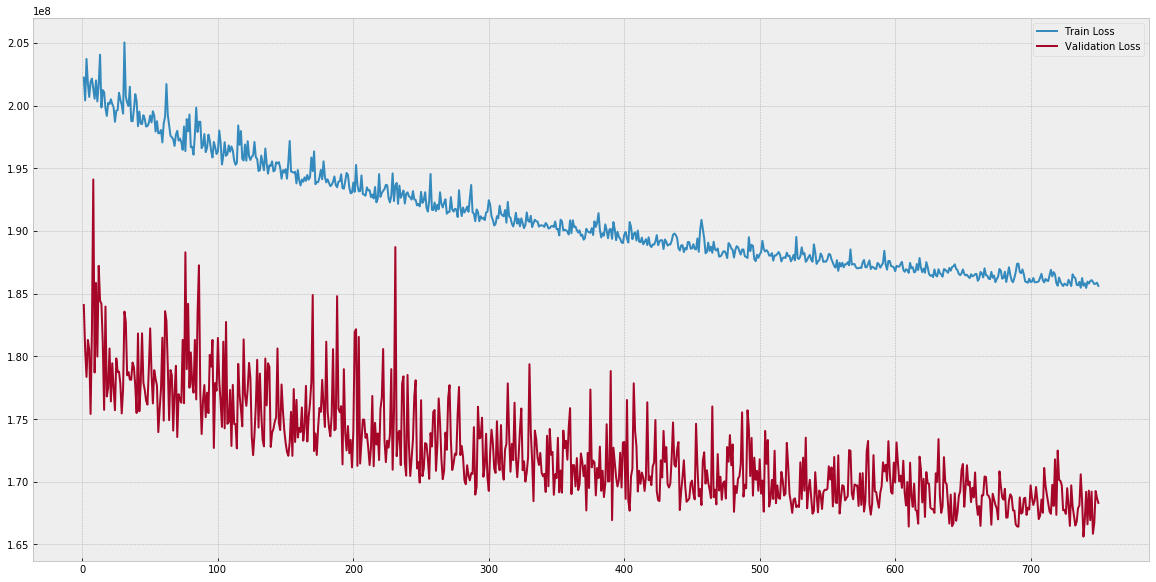

In [290]:
# Plot the train/validation loss values
plt.figure(figsize=(20,10))
_loss = history.history['loss'][250:]
_val_loss = history.history['val_loss'][250:]

train_loss_plot, = plt.plot(range(1, len(_loss)+1), _loss, label='Train Loss')
val_loss_plot, = plt.plot(range(1, len(_val_loss)+1), _val_loss, label='Validation Loss')

_ = plt.legend(handles=[train_loss_plot, val_loss_plot])

After ~500 epochs the validation_loss is very low. This would have been a very good result if this was a "real world problem", particularly because we are using a quadratic loss function (Mean Square Error) when trying to predict a large value:

In [291]:
print ("This is the average value we are trying to predict: %d" % y_val.mean().iloc[0])

This is the average value we are trying to predict: 1200713


## How good are the model's predictions?

In [292]:
df = y_val.copy()

# Add a column for the model's predicted values
df['pred'] = model.predict([X_val_continuous, X_val_categorical[['area_mapping','type_mapping']].to_numpy()])

# Calculate the difference between the predicted and the actual price
df['diff'] = df['pred'] - df['price']

# Calculate the absolute difference between the predicted and the actual price
df['abs_diff'] = np.abs(df['diff'])

# Calculate the percentage of the difference from the actual price
df['%diff'] = 100 * (df['diff'] / df['price'])

# Calculate the absolute percentage difference from the actual price
df['abs_%diff'] = np.abs(df['%diff'])

### What is the biggest difference in absolute values? 

In [293]:
# Sort by the 'abs_diff' field and show the 5 largest mistakes in absolute values
df.sort_values("abs_diff", ascending=False).head(5)

,price,pred,diff,abs_diff,%diff,abs_%diff
116,245860.0,294761.15625,48901.15625,48901.15625,19.889838,19.889838
230,244940.0,293055.03125,48115.03125,48115.03125,19.643599,19.643599
188,380860.0,417305.81250,36445.81250,36445.81250,9.569346,9.569346
253,246880.0,282640.12500,35760.12500,35760.12500,14.484821,14.484821
139,245130.0,280025.78125,34895.78125,34895.78125,14.235622,14.235622


The biggest absolute difference is ~\$537, which is less than a 0.25% of the ~\$240K house price

In [294]:
# Calculate the mean and std. of the diff field
diff_mean, diff_std = df['diff'].mean(), df['diff'].std()
print("The mean is very close to 0 ({mean}) with std. {std}.".format(mean=round(diff_mean, 2), std=round(diff_std, 2)))

The mean is very close to 0 (-1536.7) with std. 12903.54.


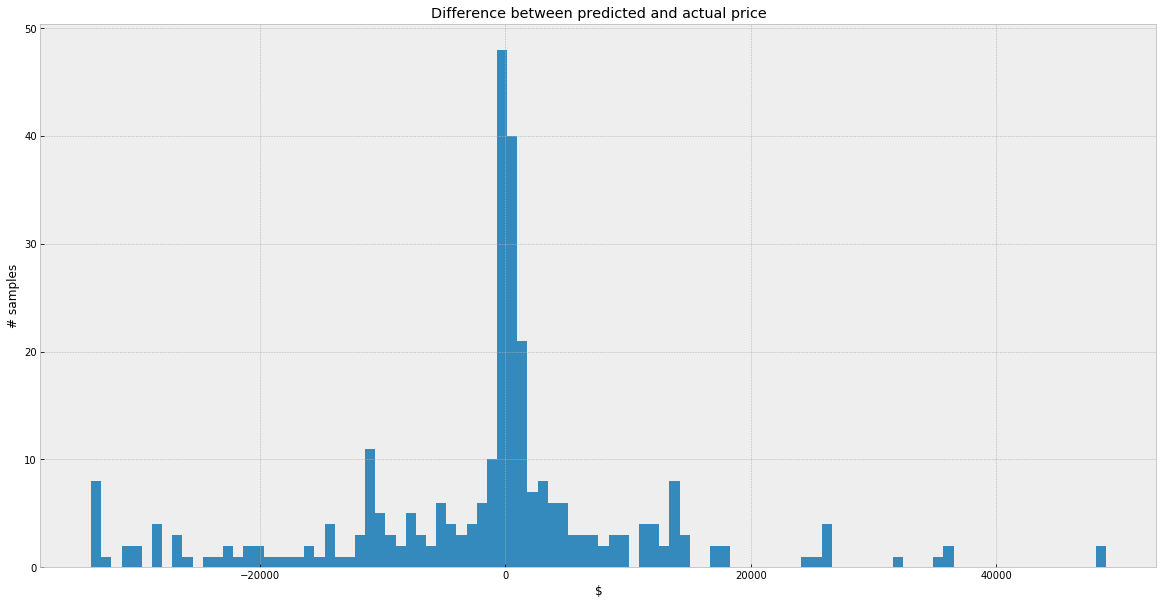

In [295]:
# Here is the histogram of the differences
plt.figure(figsize=(20,10))
plt.hist(df['diff'], bins=100)
plt.xlabel("$")
plt.ylabel("# samples")
_ = plt.title("Difference between predicted and actual price")

### What is the biggest difference in percentage?

In [296]:
# Sort by the '%diff' field and show the 5 largest proportional mistakes
df.sort_values("abs_%diff", ascending=False).head(5)

,price,pred,diff,abs_diff,%diff,abs_%diff
38,41520.0,19002.417969,-22517.582031,22517.582031,-54.233097,54.233097
85,32280.0,15047.208008,-17232.791992,17232.791992,-53.385353,53.385353
169,31580.0,15047.208008,-16532.791992,16532.791992,-52.352096,52.352096
37,37930.0,18496.292969,-19433.707031,19433.707031,-51.235716,51.235716
179,42670.0,21135.126953,-21534.873047,21534.873047,-50.468416,50.468416


The biggest absolute/percentage difference comes from the same validation sample

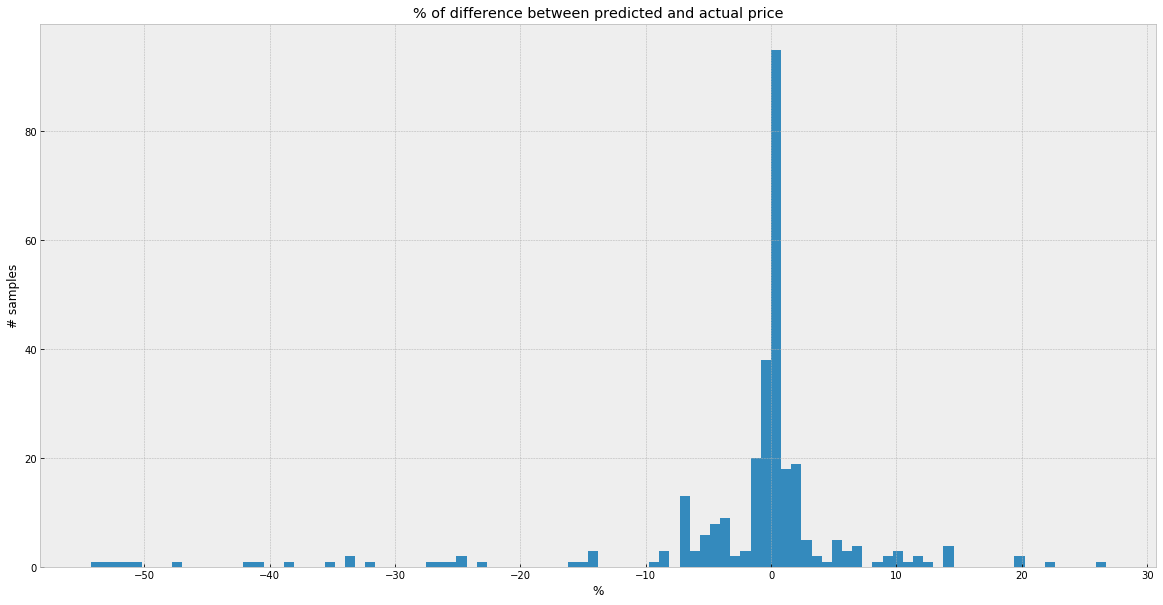

In [297]:
# Also, plot the histogram
plt.figure(figsize=(20,10))
plt.hist(df['%diff'], bins=100)
plt.xlabel("%")
plt.ylabel("# samples")
_ = plt.title("% of difference between predicted and actual price")

## Let's try and define a model with only continuous variables
It is clear from the design of the problem that the housing prices cannot be correctly predicted without the categorical variable (area). Therefore, this model will surely fail to converge, and we expect the loss to stay high  for both train/validation sets.

We will use the same simple architecture used with the embeddings model.

In [25]:
continuous_input = Input(shape=(X_train_continuous.shape[1], ))

# Define the model
units=25
dense1 = Dense(units=units, activation='relu')(continuous_input)
dense2 = Dense(units, activation='relu')(dense1)
predictions = Dense(1)(dense2)

model_cont = Model(inputs=[continuous_input], outputs=predictions)

In [26]:
#### Train the model
epochs = 10000
model_cont.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=.8, beta_1=0.9, beta_2=0.999, decay=1e-03, amsgrad=True))

history_cont = model_cont.fit([X_train_continuous], y_train, 
          epochs=epochs, batch_size=128, 
          callbacks=[periodic_logger_250], verbose=0,
          validation_data=([X_val_continuous], y_val))

Epoch: 250 - loss: 20299106041.855999 - val_loss: 20126572216.320000
Epoch: 500 - loss: 20256660488.192001 - val_loss: 20137029031.253334
Epoch: 750 - loss: 20278677695.146667 - val_loss: 20139098193.919998
Epoch: 1000 - loss: 20263610455.381332 - val_loss: 20139796616.533333
Epoch: 1250 - loss: 20258682869.077332 - val_loss: 20141625398.613335
Epoch: 1500 - loss: 20247740508.842667 - val_loss: 20142173143.040001
Epoch: 1750 - loss: 20238642124.117332 - val_loss: 20140987979.093334
Epoch: 2000 - loss: 20241048289.279999 - val_loss: 20142585255.253334
Epoch: 2250 - loss: 20238520718.677334 - val_loss: 20141372129.279999
Epoch: 2500 - loss: 20237267724.970665 - val_loss: 20143517750.613335
Epoch: 2750 - loss: 20234808781.482666 - val_loss: 20143563625.813332
Epoch: 3000 - loss: 20233952810.325333 - val_loss: 20145000611.840000
Epoch: 3250 - loss: 20243230545.237335 - val_loss: 20149649571.840000
Epoch: 3500 - loss: 20234373513.216000 - val_loss: 20141398070.613335
Epoch: 3750 - loss: 202

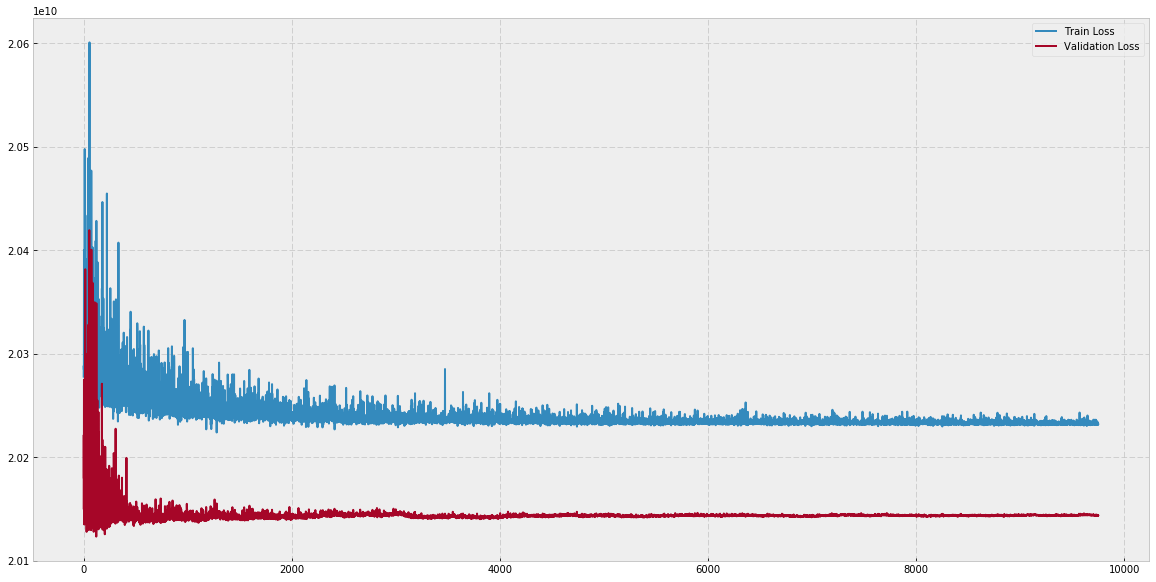

In [27]:
# Plot the train/validation loss values
plt.figure(figsize=(20,10))
_loss = history_cont.history['loss'][250:]
_val_loss = history_cont.history['val_loss'][250:]

train_loss_plot, = plt.plot(range(1, len(_loss)+1), _loss, label='Train Loss')
val_loss_plot, = plt.plot(range(1, len(_val_loss)+1), _val_loss, label='Validation Loss')

_ = plt.legend(handles=[train_loss_plot, val_loss_plot])

As expected the network failed to converge. 

Note: To actually prove the network failed to converge, a much more rigorous test should be performed (grid of different architectures, learning rates and optimizers).

In [298]:
from keras import backend as K

def r2(y_true, y_pred):
    """
    # custom R2-score metrics for keras backend
    :param y_true: 실측 데이터
    :param y_pred: 모델에 의한 예측 데이테
    :return: R^2 value, 이 값이 높다고 (예:0.99)해서 예측 값이 정확 하다고 할 수 는 없음...
    """
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res / (SS_tot + K.epsilon()))

def soft_acc(y_true, y_pred):
    delta = 600
    return K.mean(K.equal(K.round(y_true/delta), K.round(y_pred/delta)))


class VerboseCallback(keras.callbacks.Callback):
    """
    kerase.model.fit 함수에서, log 출력을 위한 callback
    """
    def __init__(self, epoch):
        self.epoch = epoch
        self.progress("learning:", 0, [])

    def progress(self, text, current=0, log=None):
        g = self.epoch - current
        f = 50 / self.epoch
        c = int(current * f)
        pg = ['=' for i in range(c)] + ['.' for i in range(50 - c)]
        print("\r" + str(text) + "{}/{}[{}]{}                                    ".format(current, self.epoch, ''.join(pg), ('' if log is None else log)),
              end="", flush=True)
        if self.epoch - current == 0:
            print("")

    def on_epoch_end(self, epoch, logs=None):
        self.progress("learning:", epoch + 1, logs)

In [299]:

train = create_samples(n_samples=1000)
val = create_samples(n_samples=100)

train['price'] = train.apply(house_price_func, axis=1)
val['price'] = val.apply(house_price_func, axis=1)


train['area'],uniques = pd.factorize(train['area'])
train['ctype'],uniques = pd.factorize(train['ctype'])
val['area'],uniques = pd.factorize(val['area'])
val['ctype'],uniques = pd.factorize(val['ctype'])

y_train = train['price']
train.drop(columns=['price'], axis=1,inplace=True)
X_train = train

y_val = val[['price']]
val.drop(columns=['price'], axis=1,inplace=True)
X_val = val

X_train

,area,size,n_rooms,ctype
0,0,21,2,0
1,1,22,2,1
2,2,29,2,2
3,0,26,4,3
4,1,18,4,1
...,...,...,...,...
2995,1,29,5,5
2996,2,26,5,0
2997,0,25,4,3
2998,1,15,4,7


In [160]:
# 파생변수 생성
X_train['area_size'] = X_train['area'] * X_train['size']
X_train['size_n_rooms'] = X_train['size'] * X_train['n_rooms']
X_train['area_n_rooms'] = X_train['area'] * X_train['n_rooms']

X_train['area_area'] = X_train['area'] * X_train['area']
X_train['size_size'] = X_train['size'] * X_train['size']
X_train['n_rooms_n_rooms'] = X_train['n_rooms'] * X_train['n_rooms']

X_val['area_size'] = X_val['area'] * X_val['size']
X_val['size_n_rooms'] = X_val['size'] * X_val['n_rooms']
X_val['area_n_rooms'] = X_val['area'] * X_val['n_rooms']

X_val['area_area'] = X_val['area'] * X_val['area']
X_val['size_size'] = X_val['size'] * X_val['size']
X_val['n_rooms_n_rooms'] = X_val['n_rooms'] * X_val['n_rooms']

In [300]:
X_val

,area,size,n_rooms,ctype
0,0,29,5,0
1,1,26,5,0
2,2,26,5,1
3,0,22,3,2
4,1,32,3,3
...,...,...,...,...
295,1,33,1,1
296,2,25,1,3
297,0,24,3,4
298,1,28,3,5


In [301]:
categorical_cols=['area','ctype']
X_train_categorical = train[categorical_cols]
X_val_categorical = X_val[categorical_cols]

train_mean = X_train.mean(axis=0)
train_std = X_train.std(axis=0)

X_train = X_train - train_mean
X_train /= train_std

X_val = X_val - train_mean
X_val /= train_std

#X_train.drop(columns=['area'], axis=1,inplace=True)
#X_val.drop(columns=['area'], axis=1,inplace=True)

In [302]:
# Define the embedding input
cate_input = Input(shape=(X_train_categorical.shape[1],), dtype='int32') 

# Decide to what vector size we want to map our 'area' variable. 
# I'll use 1 here because we only have three areas
embeddings_output = 24

# Let’s define the embedding layer and flatten it
cate_embedings = Embedding(output_dim=embeddings_output, input_dim=X_train_categorical.shape[0])(cate_input)
cate_embedings = keras.layers.Reshape((embeddings_output*X_train_categorical.shape[1],))(cate_embedings)


# Define the continuous variables input (just like before)
continuous_input = Input(shape=(X_train.shape[1], ))

# Concatenate continuous and embeddings inputs
all_input = keras.layers.concatenate([continuous_input, cate_embedings])

In [303]:

# Define the model
units=25*2
dense1 = Dense(units=units, activation='relu')(all_input)
dense2 = Dense(units, activation='relu')(dense1)
predictions = Dense(1)(dense2)

# Note using the input object 'area_input' not 'area_embeddings'
model = Model(inputs=[continuous_input, cate_input], outputs=predictions)

model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=.8, beta_1=0.9, beta_2=0.999, decay=1e-03, amsgrad=True),metrics=[soft_acc,r2])

model.summary()


Model: "model_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_62 (InputLayer)           (None, 2)            0                                            
__________________________________________________________________________________________________
embedding_40 (Embedding)        (None, 2, 24)        72000       input_62[0][0]                   
__________________________________________________________________________________________________
input_63 (InputLayer)           (None, 4)            0                                            
__________________________________________________________________________________________________
reshape_37 (Reshape)            (None, 48)           0           embedding_40[0][0]               
___________________________________________________________________________________________

In [304]:

epochs = 1000

# Note continuous and categorical columns are inserted in the same order as defined in all_inputs
history = model.fit([X_train, X_train_categorical], y_train, 
          epochs=epochs, batch_size=128, 
          callbacks=[VerboseCallback(epochs)], verbose=0,
          validation_data=([X_val, X_val_categorical], y_val))

learning:0/1000[..................................................][]                                    

c:\program files\python36\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


learning:1000/1000[==================================================]{'val_loss': 2101624980548.2666, 'val_soft_acc': 0.12831439077854156, 'val_r2': 0.0890822634100914, 'loss': 5541880.402666667, 'soft_acc': 0.4111793, 'r2': 0.9999979}                                        


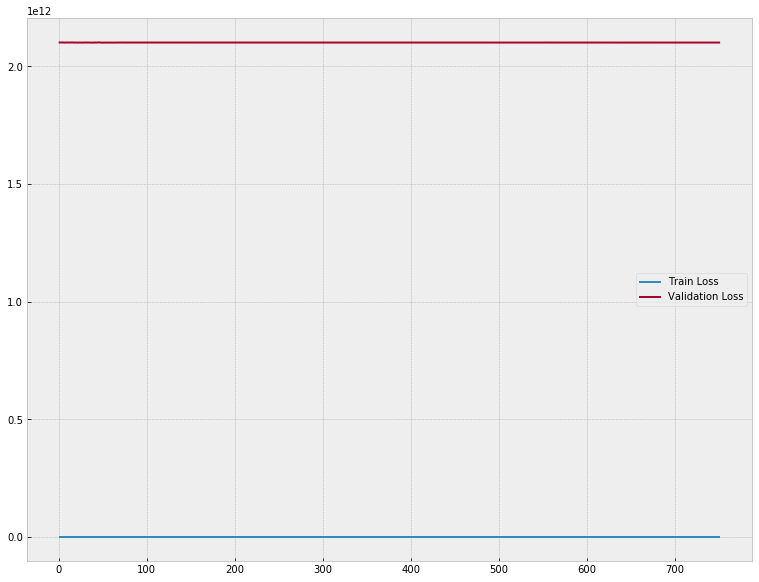

In [305]:
# Plot the train/validation loss values
plt.figure(figsize=(13,10))
_loss = history.history['loss'][250:]
_val_loss = history.history['val_loss'][250:]

train_loss_plot, = plt.plot(range(1, len(_loss)+1), _loss, label='Train Loss')
val_loss_plot, = plt.plot(range(1, len(_val_loss)+1), _val_loss, label='Validation Loss')

_ = plt.legend(handles=[train_loss_plot, val_loss_plot])


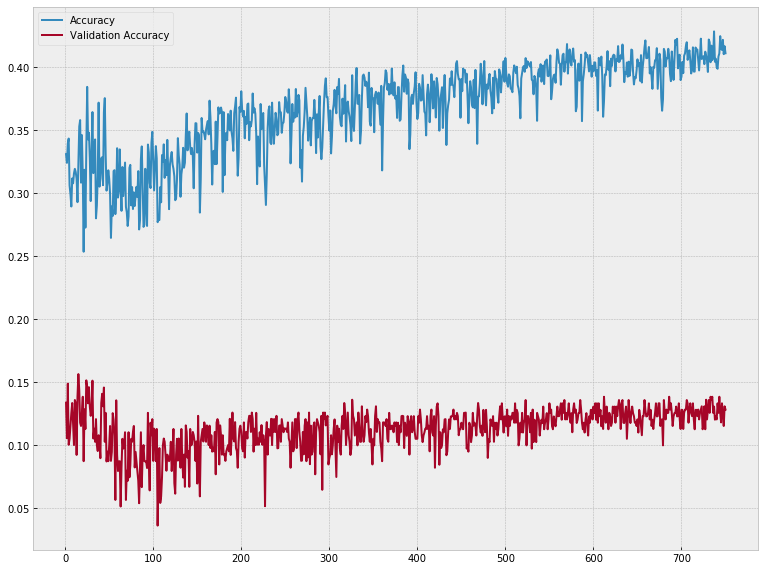

In [306]:
plt.figure(figsize=(13,10))
_acc = history.history['soft_acc'][250:]
_val_acc = history.history['val_soft_acc'][250:]

train_loss_plot, = plt.plot(range(1, len(_acc)+1), _acc, label='Accuracy')
val_loss_plot, = plt.plot(range(1, len(_val_loss)+1), _val_acc, label='Validation Accuracy')

_ = plt.legend(handles=[train_loss_plot, val_loss_plot])

The mean is very close to 0 (-55711.04) with std. 1451047.86.


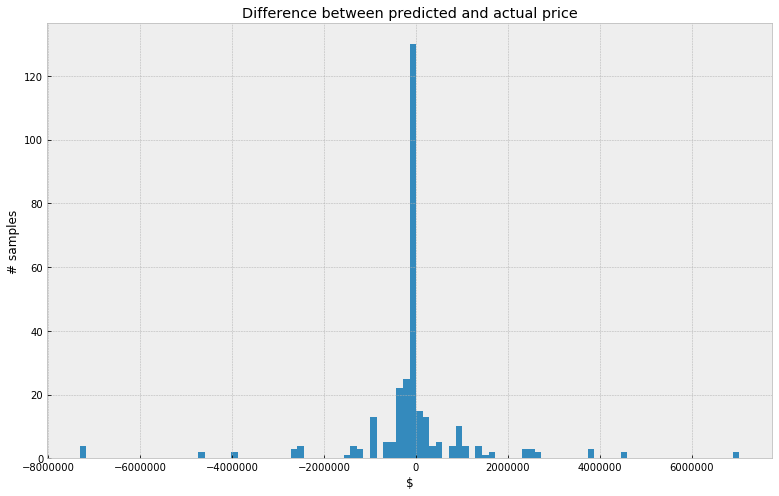

In [307]:
df = y_val.copy()

# Add a column for the model's predicted values
df['pred'] = model.predict([X_val,X_val_categorical])

# Calculate the difference between the predicted and the actual price
df['diff'] = df['pred'] - df['price']

# Calculate the absolute difference between the predicted and the actual price
df['abs_diff'] = np.abs(df['diff'])

# Calculate the percentage of the difference from the actual price
df['%diff'] = 100 * (df['diff'] / df['price'])

# Calculate the absolute percentage difference from the actual price
df['abs_%diff'] = np.abs(df['%diff'])

# Sort by the 'abs_diff' field and show the 5 largest mistakes in absolute values
df.sort_values("abs_diff", ascending=False).head(5)

# Calculate the mean and std. of the diff field
diff_mean, diff_std = df['diff'].mean(), df['diff'].std()
print("The mean is very close to 0 ({mean}) with std. {std}.".format(mean=round(diff_mean, 2), std=round(diff_std, 2)))

# Here is the histogram of the differences
plt.figure(figsize=(13,8))
plt.hist(df['diff'], bins=100)
plt.xlabel("$")
plt.ylabel("# samples")
_ = plt.title("Difference between predicted and actual price")

In [178]:

#Code here...

model = Sequential()
model.add(Dense(25,input_shape=(X_train.shape[1],),activation='relu'))
model.add(Dense(25,activation='relu'))
model.add(Dense(1))

model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=.8, beta_1=0.9, beta_2=0.999, decay=1e-03, amsgrad=True),metrics=[soft_acc,r2])

model.summary()

epochs = 1000

# Note continuous and categorical columns are inserted in the same order as defined in all_inputs
history = model.fit(X_train, y_train, 
          epochs=epochs, batch_size=128, 
          callbacks=[VerboseCallback(epochs)], verbose=0,
          validation_data=(X_val, y_val))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 25)                100       
_________________________________________________________________
dense_65 (Dense)             (None, 25)                650       
_________________________________________________________________
dense_66 (Dense)             (None, 1)                 26        
Total params: 776
Trainable params: 776
Non-trainable params: 0
_________________________________________________________________
learning:1000/1000[==================================================]{'val_loss': 1888239.2233333334, 'val_soft_acc': 0.4749052822589874, 'val_r2': 0.9999710917472839, 'loss': 2109467.908333333, 'soft_acc': 0.43354726, 'r2': 0.9999644}                                       


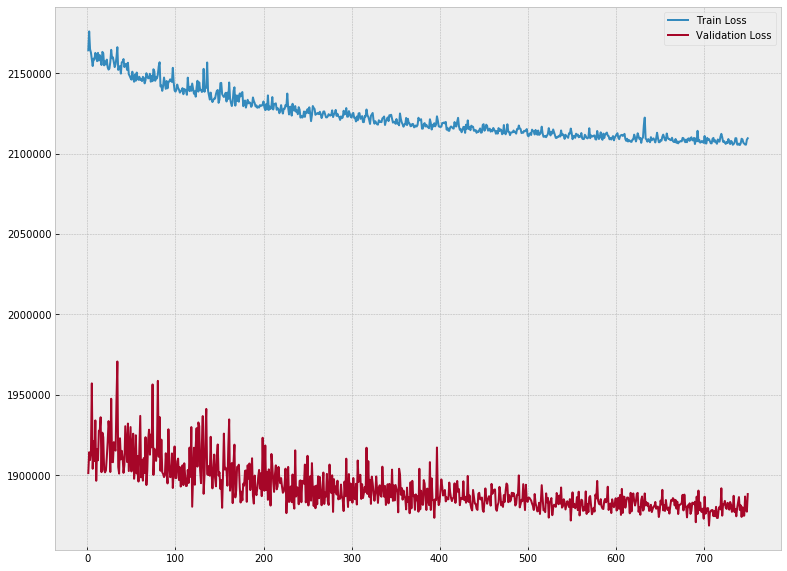

In [179]:
# Plot the train/validation loss values
plt.figure(figsize=(13,10))
_loss = history.history['loss'][250:]
_val_loss = history.history['val_loss'][250:]

train_loss_plot, = plt.plot(range(1, len(_loss)+1), _loss, label='Train Loss')
val_loss_plot, = plt.plot(range(1, len(_val_loss)+1), _val_loss, label='Validation Loss')

_ = plt.legend(handles=[train_loss_plot, val_loss_plot])


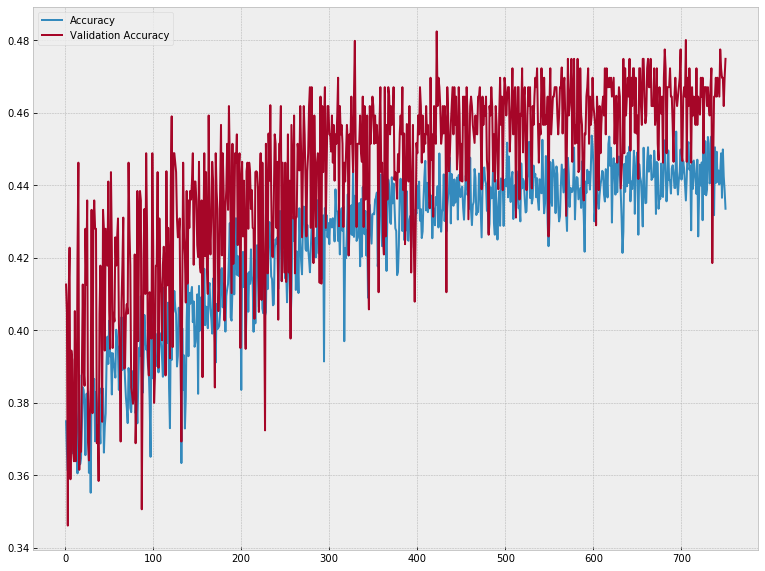

In [180]:
plt.figure(figsize=(13,10))
_acc = history.history['soft_acc'][250:]
_val_acc = history.history['val_soft_acc'][250:]

train_loss_plot, = plt.plot(range(1, len(_acc)+1), _acc, label='Accuracy')
val_loss_plot, = plt.plot(range(1, len(_val_acc)+1), _val_acc, label='Validation Accuracy')

_ = plt.legend(handles=[train_loss_plot, val_loss_plot])

The mean is very close to 0 (80.7) with std. 1374.05.


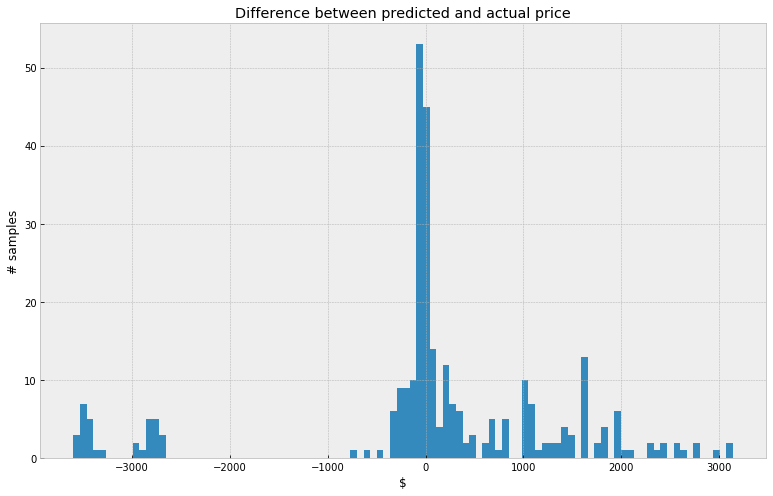

In [181]:
df = y_val.copy()

# Add a column for the model's predicted values
df['pred'] = model.predict(X_val)

# Calculate the difference between the predicted and the actual price
df['diff'] = df['pred'] - df['price']

# Calculate the absolute difference between the predicted and the actual price
df['abs_diff'] = np.abs(df['diff'])

# Calculate the percentage of the difference from the actual price
df['%diff'] = 100 * (df['diff'] / df['price'])

# Calculate the absolute percentage difference from the actual price
df['abs_%diff'] = np.abs(df['%diff'])

# Sort by the 'abs_diff' field and show the 5 largest mistakes in absolute values
df.sort_values("abs_diff", ascending=False).head(5)

# Calculate the mean and std. of the diff field
diff_mean, diff_std = df['diff'].mean(), df['diff'].std()
print("The mean is very close to 0 ({mean}) with std. {std}.".format(mean=round(diff_mean, 2), std=round(diff_std, 2)))

# Here is the histogram of the differences
plt.figure(figsize=(13,8))
plt.hist(df['diff'], bins=100)
plt.xlabel("$")
plt.ylabel("# samples")
_ = plt.title("Difference between predicted and actual price")